# Two-agent Fixed Priority Path Planning

In [1]:
import sys
sys.path.append('../')
from panav.env import NavigationEnv, Box2DRegion, PolygonRegion, box_2d_center, line_seg_to_obstacle
from panav.viz import draw_env

import shapely
import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

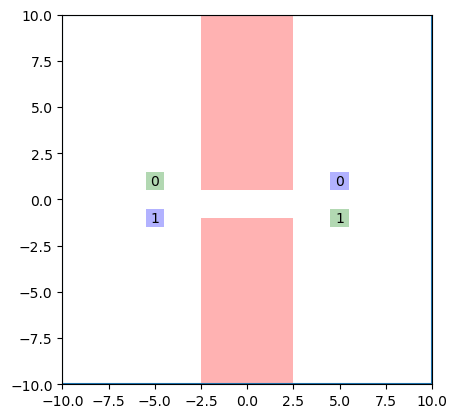

In [2]:

start_locs = np.array([[5,1],[-5,-1]])
goal_locs = np.array([[-5,1],[5,-1]])


start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

starts = [box_2d_center(s,start_box_side) for s in start_locs]

goals = [box_2d_center(g,goal_box_side) for g in goal_locs]

O1 = Box2DRegion((-2.5,2.5),(0.5,10))
O2 = Box2DRegion((-2.5,2.5),(-10,-1.0))

limits = [(-10.0,10.0),(-10.0,10.0)]

bloating_r = 0.5 

env = NavigationEnv(limits,[O1,O2],starts,goals)

draw_env(env)

In [11]:
from panav.SAMP import SA_MILP_Planning,Tube_Planning
from panav.util import unique_tx, interpolate_positions

from panav.env import line_seg_to_obstacle

In [24]:
go_agent = 0
yield_agent = 1

bloating_r = 0.5

d = 2
K = 4
t0 = 0
vmax = 1.0
interp_dt = 0.1

In [30]:
# Planning for the agent with higher priority
start = env.starts[go_agent]
goal = env.goals[go_agent]
times,xs = SA_MILP_Planning(env,start,goal,vmax,bloating_r,\
                                 [],\
                                d,K,t0)

# times,xs = Tube_Planning(env,start,goal,vmax,bloating_r,\
#                                  [],\
#                                 d,K,t0)

times,xs = unique_tx(times,xs)

In [31]:
# Convert the agent's path into temporary obstacle.
temp_obstacles = []
for k in range(xs.shape[-1]-1):
    temp_obstacles.append(([times[k],times[k+1]], line_seg_to_obstacle(xs[:,k],xs[:,k+1],bloating_r)))

In [32]:
# Planning for the agent with lower priority
start = env.starts[yield_agent]
goal = env.goals[yield_agent]
t2,x2 = SA_MILP_Planning(env,start,goal,vmax,bloating_r,\
                                 temp_obstacles,\
                                d,K,t0)

# t2,x2 = Tube_Planning(env,start,goal,vmax,bloating_r,\
#                                  [(times,xs)],\
#                                 d,K,t0)

t2,x2 = unique_tx(t2,x2)

In [33]:
print('flowtime',times[-1]+t2[-1])

flowtime 36.65014940844167


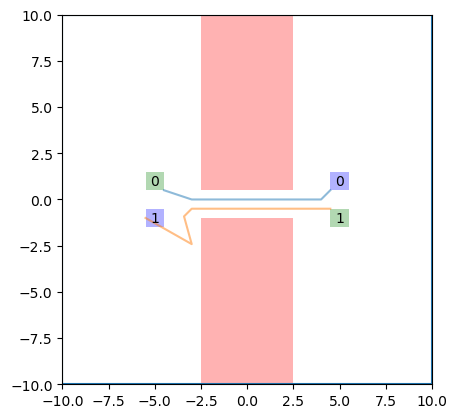

In [34]:
draw_env(env,[xs,x2])

# Animation

In [35]:
from panav.viz import animation
from IPython.display import HTML, display

In [36]:
times,xs = interpolate_positions(times,xs,interp_dt)
t2,x2 = interpolate_positions(t2,x2,interp_dt)

pos = [xs,x2]
anim = animation(env, pos, bloating_r, dt = interp_dt / 4)
display(HTML(anim.to_jshtml()))
plt.close()   # Avoid plotting an extra figure.